<a href="https://colab.research.google.com/github/june1st/GoogleColab/blob/master/Stateful-lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!df -h 

Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   32G   34G  49% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
tmpfs           6.4G   12K  6.4G   1% /var/colab
/dev/sda1        75G   37G   39G  50% /opt/bin
shm             5.9G  4.0K  5.9G   1% /dev/shm
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [1]:
!nvidia-smi

Tue Dec 24 23:33:21 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [23]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 / 60 / 60 "h)"}'

0.0132686days (0.318447h)


         t     sin_t
0        0  1.025200
1        1  1.242131
2        2  1.486475
3        3  1.648822
4        4  1.786828
...    ...       ...
3996  3996 -0.026306
3997  3997  0.185880
3998  3998  0.431234
3999  3999  0.729979
4000  4000  0.979632

[4001 rows x 2 columns]


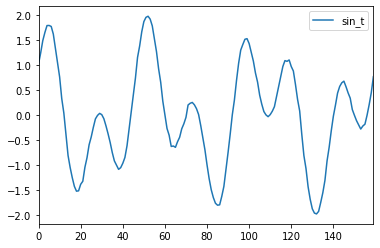

In [106]:
import pandas as pd
import numpy as np
import math
import random
%matplotlib inline
random.seed(0)
# 乱数の係数
random_factor = 0.05
# サイクルあたりのステップ数
steps_per_cycle = 80
# 生成するサイクル数
number_of_cycles = 50

df = pd.DataFrame(np.arange(steps_per_cycle * number_of_cycles + 1), columns=["t"])
df["sin_t"] = df.t.apply(lambda x: math.cos(x * (3 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor)+math.sin(x * (7 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor))
#df["sin_t"] = df.t.apply(lambda x: math.sin(x * (7 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor))
df[["sin_t"]].head(steps_per_cycle * 2).plot()

print(df)

In [0]:
def _load_data(data, n_prev = 100):  
    """
    data should be pd.DataFrame()
    """
    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def train_test_split(df, test_size=0.1, n_prev = 100):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(df) * (1 - test_size))
    ntrn = int(ntrn)
    X_train, y_train = _load_data(df.iloc[0:ntrn], n_prev)
    X_test, y_test = _load_data(df.iloc[ntrn:], n_prev)

    return (X_train, y_train), (X_test, y_test)

In [111]:
length_of_sequences = 100
(X_train, y_train), (X_test, y_test) = train_test_split(df[["sin_t"]], n_prev =length_of_sequences) 

         sin_t
0     1.025200
1     1.242131
2     1.486475
3     1.648822
4     1.786828
...        ...
3596 -0.012628
3597 -0.188155
3598 -0.463351
3599 -0.735549
3600 -1.005321

[3601 rows x 1 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


         sin_t
3601 -1.240232
3602 -1.544520
3603 -1.690144
3604 -1.771876
3605 -1.821914
...        ...
3996 -0.026306
3997  0.185880
3998  0.431234
3999  0.729979
4000  0.979632

[400 rows x 1 columns]


In [27]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM


in_out_neurons = 1
hidden_neurons = 300

model = Sequential()  
model.add(LSTM(hidden_neurons, batch_input_shape=(None, length_of_sequences, in_out_neurons), return_sequences=False, stateful=False))  
model.add(Dense(in_out_neurons))  
model.add(Activation("linear"))  
model.compile(loss="mean_squared_error", optimizer="rmsprop")
model.fit(X_train, y_train, batch_size=600, nb_epoch=15, validation_split=0.05) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 3325 samples, validate on 176 samples
Epoch 1/15
3325/3325 [==============================] - 2s 502us/step - loss: 0.5721 - val_loss: 0.1765
Epoch 2/15
3325/3325 [==============================] - 1s 283us/step - loss: 0.1895 - val_loss: 0.1098
Epoch 3/15
3325/3325 [==============================] - 1s 287us/step - loss: 0.3419 - val_loss: 0.0667
Epoch 4/15
3325/3325 [==============================] - 1s 286us/step - loss: 0.0520 - val_loss: 0.0376
Epoch 5/15
3325/3325 [==============================] - 1s 281us/step - loss: 0.0580 - val_loss: 0.0445
Epoch 6/15
3325/3325 [==============================] - 1s 287us/step - loss: 0.0321 - val_loss: 0.0090
Epoch 7/15
3325/3325 [==============================] - 1s 289us/step - loss: 0.0385 - val_loss: 0.0237
Epoch 8/15
3325/3325 [==============================] - 1s 284us/step - loss: 0.0147 - val_loss: 0.0355
Epoch 9/15
3325/3325 [==============================] - 1s 287us/step - loss: 0.0294 - val_loss: 0.0061
Epoch 10/15
3325/

In [0]:
model.save_weights('/tmp/param.hdf5')

In [29]:
#model_stateful = create_model(batch_size = 1, stateful=True)
model_stateful = Sequential()  
model_stateful.add(LSTM(hidden_neurons, batch_input_shape=(1, None, 1), return_sequences=False, stateful=True))  
model_stateful.add(Dense(1))  
model_stateful.add(Activation("linear"))  
model_stateful.compile(loss="mean_squared_error", optimizer="rmsprop")
model_stateful.load_weights('/tmp/param.hdf5')
model_stateful.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (1, 300)                  362400    
_________________________________________________________________
dense_4 (Dense)              (1, 1)                    301       
_________________________________________________________________
activation_4 (Activation)    (1, 1)                    0         
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


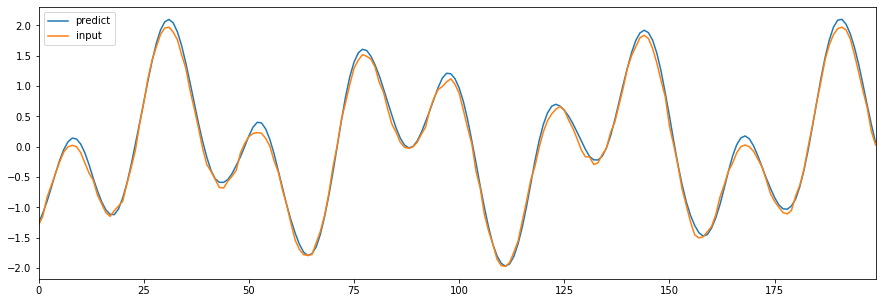

In [86]:
predicted = model.predict(X_test) 

dataf =  pd.DataFrame(predicted[:200])
dataf.columns = ["predict"]
dataf["input"] = y_test[:200]
dataf.plot(figsize=(15, 5))

In [42]:
predict_len = 190
start = 10
data=X_test[0]
result=[]
#for n in range(predict_len):
s = 0
for n in range(predict_len):
    # give just new 1 timestep
    s =  data[start+n-1:start+n].reshape( (1, 1, 1) )
    predicted = model_stateful.predict( s )
    #predicted = model_stateful.predict( data[start+n-1:start+n].reshape( (1, 1, 1) ) )
    result.append(predicted[0])

ValueError: ignored

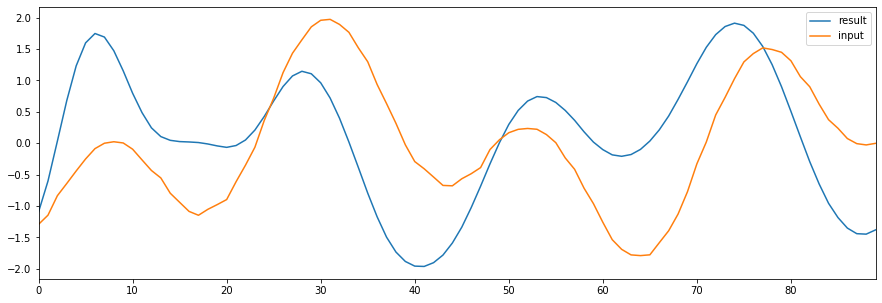

In [41]:
dataf =  pd.DataFrame(result)
dataf.columns = ["result"]
dataf["input"] = y_test[:len(result)]
dataf.plot(figsize=(15, 5))

In [33]:
np.shape(X_test[0][0])


(1,)

In [34]:
X_test[0][0].reshape(1,1,1)

array([[[-1.24023191]]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


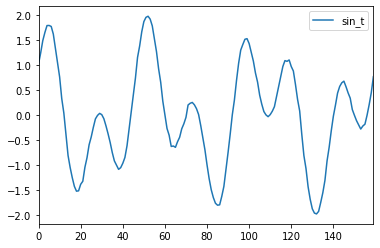

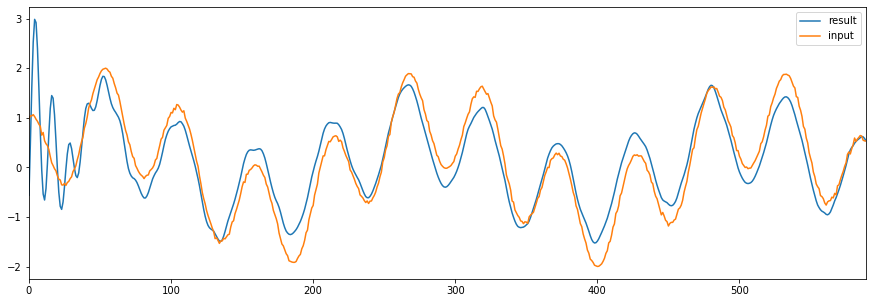

In [82]:
random.seed(0)
# 乱数の係数
random_factor = 0.05
# サイクルあたりのステップ数
steps_per_cycle = 80
# 生成するサイクル数
number_of_cycles = 50

df = pd.DataFrame(np.arange(steps_per_cycle * number_of_cycles + 1), columns=["t"])
df["sin_t"] = df.t.apply(lambda x: math.cos(x * (3 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor)+math.sin(x * (7 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor))
#df["sin_t"] = df.t.apply(lambda x: math.sin(x * (7 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor))
df[["sin_t"]].head(steps_per_cycle * 2).plot()

length_of_sequences = 100
(X_train2, y_train2), (X_test2, y_test2) = train_test_split(df[["sin_t"]], n_prev =length_of_sequences) 

predict_len = 590
start = 1
data=y
result=[]
#for n in range(predict_len):
s = 0
for n in range(predict_len):
    # give just new 1 timestep
    s =  data[start+n-1:start+n]#.reshape( (1, 1, 1) )
    predicted = model_stateful.predict( [[[s]]] )
    #predicted = model_stateful.predict( data[start+n-1:start+n].reshape( (1, 1, 1) ) )
    result.append(predicted[0])

dataf =  pd.DataFrame(result)
dataf.columns = ["result"]
dataf["input"] = y[:len(result)]
#dataf["input2"] = y_test[:len(result)]
dataf.plot(figsize=(15, 5))

In [0]:
u = (lambda x: math.cos(x * (3 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor)+math.sin(x * (7 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor))

In [0]:
x = np.arange(0, 1000, 0.1)
u = (lambda x: math.cos(x * (30 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor)+math.sin(x * (7 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor))
y = list(map(u, x))

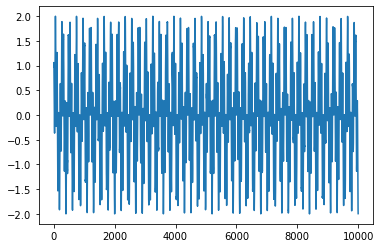

In [80]:
import matplotlib.pyplot as plt
plt.plot(y)

(10000,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


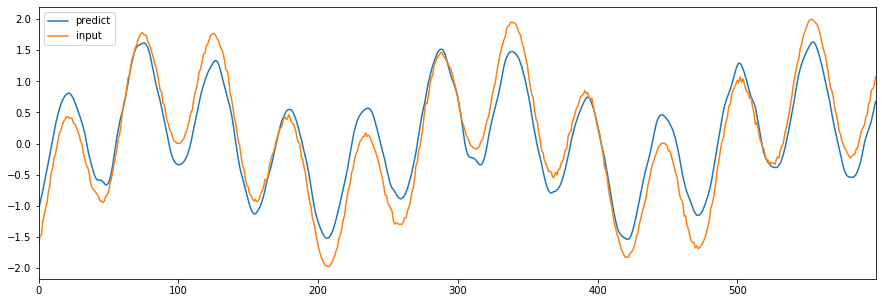

In [122]:
print(np.shape(y))

def _load_data2(data, n_prev = 100):  
    """
    data should be pd.DataFrame()

    """
    data = pd.DataFrame(data)

    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY
def train_test_split2(dat, test_size=0.1, n_prev = 100):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(dat) * (1 - test_size))
    ntrn = int(ntrn)
    X_train, y_train = _load_data2(dat[0:ntrn], n_prev)
    X_test, y_test = _load_data2(dat[ntrn:], n_prev)

    return (X_train, y_train), (X_test, y_test)

(xxx, yyy),(xx, yy) = train_test_split2(y)

predicted = model.predict(xx)

dataf =  pd.DataFrame(predicted[:600])
dataf.columns = ["predict"]
dataf["input"] = yy[:600]
dataf.plot(figsize=(15, 5))